# Verify Image Processing

## Config

In [1]:
REFEXP_DATASET_NAME = "ivelin/ui_refexp_saved"

MAX_LENGTH = 128
IMAGE_HEIGHT = 1280
IMAGE_WIDTH = 960
IMAGE_SIZE = [IMAGE_HEIGHT, IMAGE_WIDTH]

config = {
    "dataset":REFEXP_DATASET_NAME,
    "max_length":MAX_LENGTH,
    "image_height":IMAGE_HEIGHT,
    "image_width":IMAGE_WIDTH,
    "image_size":IMAGE_SIZE
}

## Load Dataset

In [2]:
from datasets import load_dataset
from datasets.download.download_manager import DownloadMode #, REUSE_DATASET_IF_EXISTS, REUSE_CACHE_IF_EXISTS


config["split"] = "train"

train_ds = load_dataset(REFEXP_DATASET_NAME, split=config["split"], num_proc=8, download_mode=DownloadMode.FORCE_REDOWNLOAD)
train_ds

Using custom data configuration ivelin--ui_refexp_saved-6916d19d5dad9975


Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #2:   0%|          | 0/1 [00:00<?, ?obj/s]

Setting num_proc from 8 back to 1 for the test split to disable multiprocessing as it only contains one shard.


Generating test split:   0%|          | 0/565 [00:00<?, ? examples/s]

Setting num_proc from 8 back to 1 for the validation split to disable multiprocessing as it only contains one shard.


Generating validation split:   0%|          | 0/471 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/15624 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /home/jupyter/.cache/huggingface/datasets/ivelin___parquet/ivelin--ui_refexp_saved-6916d19d5dad9975/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


Dataset({
    features: ['image', 'image_id', 'image_file_path', 'prompt', 'target_bounding_box'],
    num_rows: 15624
})

## Transforms

In [3]:
import ast 

def bbox_preprocess(bbox):
    '''
        convert string bboxes to dict
    '''
    
    if isinstance(bbox, str): 
        return ast.literal_eval(bbox)
    else: return bbox

In [4]:
import albumentations as A
from albumentations import RandomBrightnessContrast
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.augmentations.transforms import Normalize
from albumentations.augmentations.geometric.resize import LongestMaxSize


transform = A.Compose(
    [
        # rescale
        LongestMaxSize(max_size=IMAGE_HEIGHT, interpolation=1, 
                       always_apply=True, p=1),
        
        # adjust brightness & contrast
        RandomBrightnessContrast(p=0.3),
        
        # normalize with imagenet stats, as per original Donut codebase
        Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), 
                   max_pixel_value=255.0, always_apply=True, p=1.0),
        
        # convert to pytorch tensor
        ToTensorV2(transpose_mask=False, always_apply=True, p=1.0)
    ],
    # rescale bounding boxes appropriately
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

transform_no_normalize = A.Compose(
    [
        # rescale
        LongestMaxSize(max_size=IMAGE_HEIGHT, interpolation=1, 
                       always_apply=True, p=1),
        
        # adjust brightness & contrast
        RandomBrightnessContrast(p=0.3),
        
        # # normalize with imagenet stats, as per original Donut codebase
        # Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), 
        #            max_pixel_value=255.0, always_apply=True, p=1.0),
        
        # convert to pytorch tensor
        ToTensorV2(transpose_mask=False, always_apply=True, p=1.0)
    ],
    # rescale bounding boxes appropriately
    bbox_params=A.BboxParams(format="pascal_voc", label_fields=['class_labels']),
)

Update config

In [5]:
# log transforms used
config["transforms"] = transform.to_dict()["transform"]["transforms"]

config["transforms_no_normalize"] = transform_no_normalize.to_dict()["transform"]["transforms"]

In [6]:
import torch
import numpy as np

def transforms(examples):
    '''
        Based on: https://huggingface.co/docs/datasets/object_detection
    '''
    images, bboxes, raw_images, original_bboxes = [], [], [], []
    unnormalized_images = []
    class_labels = ['dummy']
    
    for image, bbox in zip(examples['image'], examples['target_bounding_box']):
        raw_image = image
        
        # Get Bounding Boxes
        width, height = image.size
        
        bbox = bbox_preprocess(bbox)
        xmin = bbox["xmin"]
        xmax = bbox["xmax"]
        ymin = bbox["ymin"]
        ymax = bbox["ymax"]
        boxes_xyxy = [[xmin*width, ymin*height, xmax*width, ymax*height, "dummy"]]
        
        # Transform Image
        if image.mode != "RGB":
            image = np.array(image.convert("RGB"))
        else:
            image = np.array(image)
        
        # RGB Image -> BGR Numpy array (for Albumentations)
        image = np.flip(image, -1)

        # print(image.ndim)
        # print(image.shape)
        # print(image.max())
        # print(image[:,:,0].mean())
        # print(image[:,:,1].mean())
        # print(image[:,:,2].mean())

        out = transform(
                image=image, 
                bboxes=boxes_xyxy, 
                class_labels=class_labels
            )
            
        ununorm_out = transform_no_normalize(
            image=image, 
            bboxes=boxes_xyxy, 
            class_labels=class_labels
        )
        
        # print(out['image'].mean())
        # print(out['image'][0,:,:].mean())
        # print(out['image'][1,:,:].mean())
        # print(out['image'][2,:,:].mean())
        
        # BGR Numpy array -> RGB Tensor
        images.append(torch.tensor(out['image']).flip(0)) 
        bboxes.append(torch.tensor(out['bboxes'][0][:-1], dtype=torch.float16))
        raw_images.append(torch.tensor(np.array(raw_image)).permute(2,0,1))
        original_bboxes.append(torch.tensor(boxes_xyxy[0][:-1], dtype=torch.float16)) 
        
        unnormalized_images.append(torch.tensor(ununorm_out['image']).flip(0)) 
    return {'image': images, 'bbox': bboxes, 
            'prompt':examples["prompt"], 
            'raw_image': raw_images, "original_bbox": original_bboxes,
            'unnormalized_image': unnormalized_images
           }  

## Set Transforms and Test on 1

In [256]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

train_ds.set_transform(transforms)

In [257]:
example["raw_image"].size()

torch.Size([3, 1920, 1080])

In [258]:
example = train_ds[800]
example["image"].shape, example["image"].dtype, example["image"].max(), example["image"].min()

tensor(-1.3701)
tensor(-1.3873)
tensor(-1.4456)
tensor(-1.2774)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(torch.Size([3, 1280, 720]), torch.float32, tensor(2.6400), tensor(-2.1179))

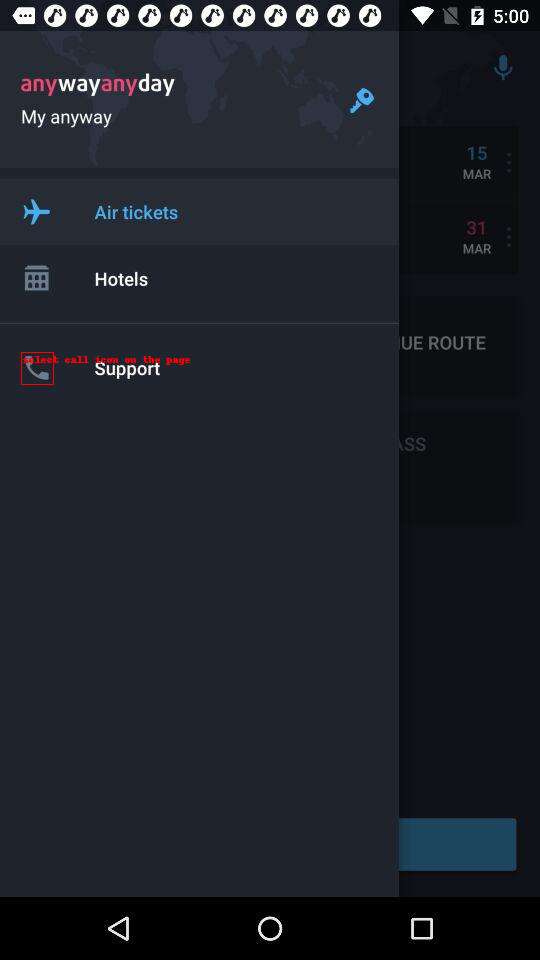

In [238]:
# Original image
img = example['raw_image'].to(dtype=torch.uint8)
bb = example['original_bbox'].unsqueeze(0)
prmt = [example['prompt']]

to_pil_image(draw_bounding_boxes(img, bb, colors='red', labels=prmt))

select call icon on the page


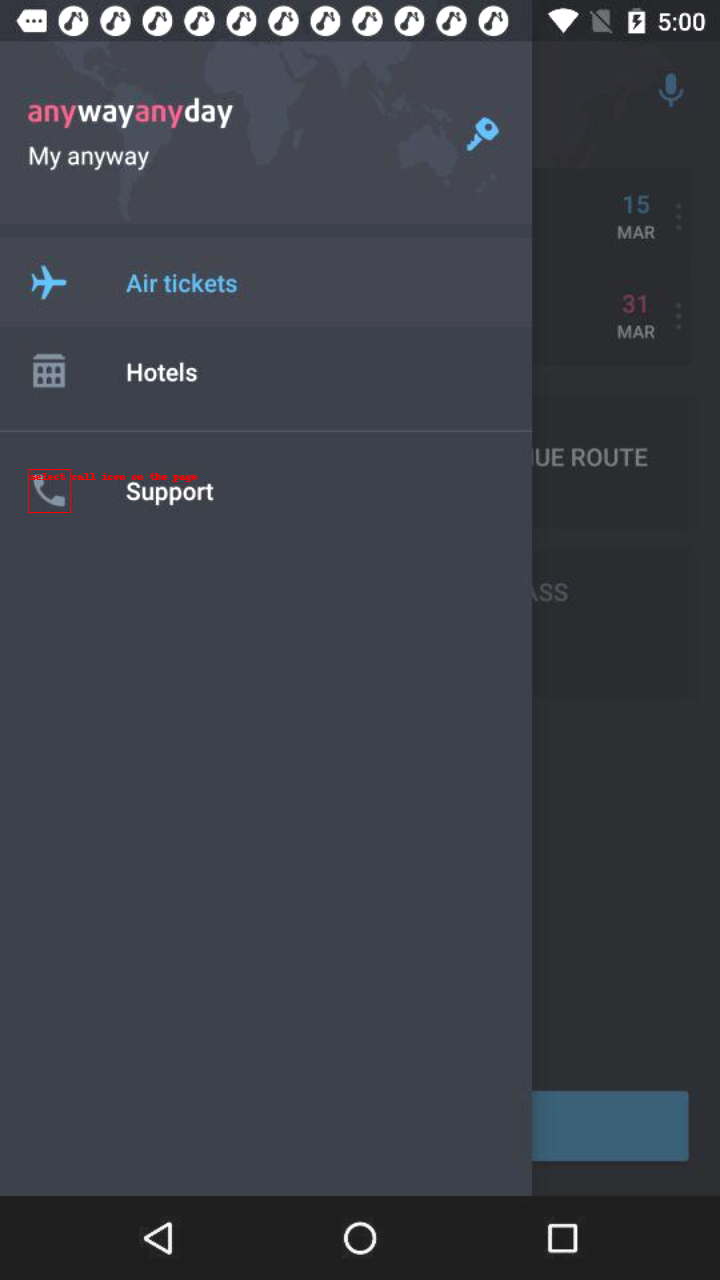

In [239]:
print(example["prompt"])

to_pil_image(
    draw_bounding_boxes(
        example['unnormalized_image'].to(dtype=torch.uint8),
        example['bbox'].unsqueeze(0),
        colors='red',
        labels=[example['prompt']]
    )
)

## Calc dataset stats

In [7]:
# based on : https://gist.github.com/jdhao/9a86d4b9e4f79c5330d54de991461fd6
class CalcDatasetStats:
    def __init__(self):
        self.channel_num = 3
        self.pixel_num = 0
        self.channel_sum = np.zeros(self.channel_num)
        self.channel_sum_squared = np.zeros(self.channel_num)
    
    def update(self, image):
        image = image.numpy()
        self.pixel_num += (image.size/self.channel_num)
        self.channel_sum += np.sum(image, axis=(1, 2))
        self.channel_sum_squared += np.sum(np.square(image), axis=(1, 2))
    
    def calc_stats(self):
        self.rgb_mean = self.channel_sum / self.pixel_num
        self.rgb_std = (np.sqrt(self.channel_sum_squared / self.pixel_num) - np.square(self.rgb_mean))
        
        return self.rgb_mean, self.rgb_std

In [9]:
# # test (needs pytorch images)
# ds_stats = CalcDatasetStats()

# for i,v in enumerate(train_ds):
#     ds_stats.update(v['image'])
    
#     if i > 5: break
    
# ds_stats.calc_stats()

## Log all train image samples to Weigths & Biases

In [11]:
train_ds.set_transform(transforms)

In [14]:
import wandb

# Set up wandb Table
columns = ["prompt", "raw_image", "processed_image_no_norm", "processed_image", 
           "raw_h", "raw_w", "proc_h", "proc_w"]
wandb_table = wandb.Table(columns=columns)

In [ ]:
from tqdm.notebook import tqdm
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

wandb.init(entity="ui-control", project="ui-control", config=config)

ds_stats = CalcDatasetStats()

# for i,example in tqdm(enumerate(train_ds)):
for example in tqdm(train_ds):
    
    img = example['raw_image']
    bb = example['original_bbox']
    prmt = [example['prompt']]
    
    # Raw images
    raw_out = to_pil_image(draw_bounding_boxes(img.to(dtype=torch.uint8), bb.unsqueeze(0), colors='red', labels=prmt))
    raw_out_h = int(raw_out.size[1])
    raw_out_w = int(raw_out.size[0])
    
    raw_out_wandb = wandb.Image(raw_out, caption = prmt[0])
    
    # Processed output, including normalization
    proc_img = example['image']
    proc_img_h = int(proc_img.shape[1])
    proc_img_w = int(proc_img.shape[2])
    proc_bb = example['bbox']
    
    proc_out = to_pil_image(draw_bounding_boxes(proc_img.to(dtype=torch.uint8), proc_bb.unsqueeze(0), colors='red', labels=prmt))
    proc_out_wandb = wandb.Image(proc_out, caption = prmt[0])
    
    # Update dataset stats for processed image
    ds_stats.update(proc_img)

    # Un-normalized, processed output
    proc_img_unnorm = example['image']
    
    proc_out_unnorm = to_pil_image(draw_bounding_boxes(proc_img_unnorm.to(dtype=torch.uint8), proc_bb.unsqueeze(0), colors='red', labels=prmt))
    proc_out_unnorm_wandb = wandb.Image(proc_out_unnorm, caption = prmt[0])
    
    # Add all images and data to a wandb Table
    wandb_table.add_data(prmt[0], raw_out_wandb, proc_out_unnorm_wandb, proc_bb,
                        raw_out_h, raw_out_w, proc_img_h, proc_img_w)
    
    # if i > 5: break

# Calculate dataset stats
ds_img_mean, ds_image_std = ds_stats.calc_stats()

wandb.summary["ds_img_mean"] = ds_img_mean
wandb.summary["ds_image_std"] = ds_image_std

wandb.log({"dataset/processed_train_dataset":wandb_table})
wandb.finish()

ds_img_mean, ds_image_std

  0%|          | 0/15624 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
ds_img_mean, ds_image_std